# Facial Expression Recognition using MediaPipe and Machine Learning

## Project Overview

This notebook demonstrates a comprehensive facial expression recognition system that classifies emotions (happy vs sad) using facial landmarks extracted from images. The project employs multiple machine learning approaches including:

- **Deep Neural Networks** with hyperparameter tuning
- **Random Forest** and **Extra Trees** ensemble methods  
- **Support Vector Machines** with different kernels

## Key Features

- MediaPipe-based facial landmark extraction (468 landmarks per face)
- Data preprocessing with SMOTE for handling class imbalance
- Comprehensive model comparison and evaluation
- Cross-validation for robust performance assessment
- Detailed visualization of results and model performance

## Dataset
The dataset is Affect net happy sad
:
**[dataset link](https://www.kaggle.com/datasets/eldarsharapov/affect-net-happy-sad)**

The dataset contains facial images categorized into two emotion classes:
- **Happy**: Positive emotion expressions
- **Sad**: Negative emotion expressions

## Methods

1. **Feature Extraction**: MediaPipe Face Mesh for 468 3D facial landmarks
2. **Data Preprocessing**: Train-test split, data shuffling, SMOTE oversampling
3. **Model Training**: Neural Networks, Random Forest, Extra Trees, SVM
4. **Evaluation**: Accuracy, Confusion Matrix, ROC-AUC, Cross-validation

## 1. Import Required Libraries

Import all necessary libraries for data processing, machine learning, visualization, and facial landmark detection.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2
import mediapipe as mp
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint , ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

In [7]:
# Define the main directory containing emotion-labeled image folders
# Update this path to match your dataset location
main_folder = r"D:\4th Biomedical\2nd semister\POs_NEg"

## 2. Data Loading and Preprocessing

Load the dataset and prepare file paths and labels for processing.

In [8]:
# Collect all image paths and their corresponding labels
# The folder structure should be: main_folder/section/emotion_label/image_files
paths, labels = [], []

for sec in os.listdir(main_folder):
    sec_path = os.path.join(main_folder, sec)
    for label in os.listdir(sec_path):
        label_path = os.path.join(sec_path, label)
        for file in os.listdir(label_path):
            paths.append(os.path.join(label_path, file))
            labels.append(label)

In [9]:
# Create DataFrame and prepare train-test split
data = pd.DataFrame({"path": paths, "label": labels})
data = data.sample(frac=1).reset_index(drop=True)  # Shuffle the data

# Split data into training and testing sets (80-20 split)
train, test = train_test_split(data, test_size=0.2, random_state=42, stratify=data['label'])

print(f"Total samples: {len(data)}")
print(f"Training samples: {len(train)}")
print(f"Testing samples: {len(test)}")

Total samples: 11000
Training samples: 8800
Testing samples: 2200


## 3. Feature Extraction using MediaPipe

Extract facial landmarks from images using MediaPipe Face Mesh. Each face is represented by 468 landmarks with (x, y, z) coordinates, resulting in 1404 features per image.

In [10]:
def extract_features(dataframe):
    """
    Extract facial landmarks from images using MediaPipe Face Mesh.
    
    Args:
        dataframe (pd.DataFrame): DataFrame containing 'path' and 'label' columns
        
    Returns:
        tuple: (features, labels) where features is a list of landmark arrays
               and labels is a list of corresponding emotion labels
    """
    features = []
    labels = []
    
    for index, row in dataframe.iterrows():
        image_path = row['path']
        image = cv2.imread(image_path)
        
        # Skip corrupted or unreadable images
        if image is None:
            continue
            
        # Initialize MediaPipe Face Mesh
        mp_face_mesh = mp.solutions.face_mesh
        with mp_face_mesh.FaceMesh(
            static_image_mode=True,
            refine_landmarks=False,
        ) as face_mesh:
            results = face_mesh.process(image)
        
        # Skip images where no face is detected
        if not results.multi_face_landmarks:
            continue
            
        # Extract landmarks from the first detected face
        landmarks = results.multi_face_landmarks[0]
        feature = []
        
        # Flatten 3D coordinates (x, y, z) for all 468 landmarks
        for landmark in landmarks.landmark:
            feature.append(landmark.x)
            feature.append(landmark.y)
            feature.append(landmark.z)
            
        feature = np.array(feature)
        features.append(feature)
        labels.append(row['label'])
        
    print(f"Successfully extracted features from {len(features)} images")
    return features, labels

In [11]:
# Extract features from training set
print("Extracting features from training data...")
x_train, y_train = extract_features(train)

Extracting features from training data...
Successfully extracted features from 8501 images
Successfully extracted features from 8501 images


In [12]:
# Extract features from testing set
print("Extracting features from testing data...")
x_test, y_test = extract_features(test)

Extracting features from testing data...
Successfully extracted features from 2116 images
Successfully extracted features from 2116 images


## 4. Data Analysis and Visualization

Analyze the distribution of emotion classes in our dataset to understand data balance and characteristics.

In [13]:
# Analyze class distribution in training and testing sets
from collections import Counter

train_dist = Counter(y_train)
test_dist = Counter(y_test)

print("=== Dataset Distribution Analysis ===")
print(f"Training data distribution: {train_dist}")
print(f"Testing data distribution: {test_dist}")
print(f"\nTotal training samples: {sum(train_dist.values())}")
print(f"Total testing samples: {sum(test_dist.values())}")

# Calculate class balance ratio
classes = list(train_dist.keys())
if len(classes) == 2:
    ratio = max(train_dist.values()) / min(train_dist.values())
    print(f"Class imbalance ratio: {ratio:.2f}:1")


=== Dataset Distribution Analysis ===
Training data distribution: Counter({'happy': 4319, 'sad': 4182})
Testing data distribution: Counter({'happy': 1079, 'sad': 1037})

Total training samples: 8501
Total testing samples: 2116
Class imbalance ratio: 1.03:1


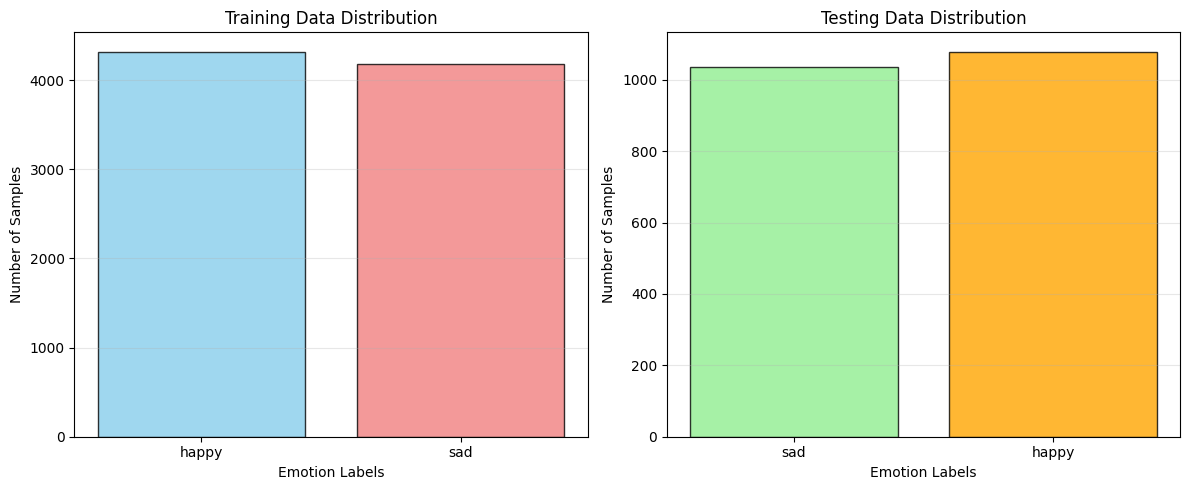


Feature dimensions: 1404 features per sample
Expected: 468 landmarks × 3 coordinates = 1404 features


In [14]:
plt.figure(figsize=(12, 5))

# Training data distribution
plt.subplot(1, 2, 1)
train_counts = Counter(y_train)
plt.bar(train_counts.keys(), train_counts.values(), 
        color=['skyblue', 'lightcoral'], alpha=0.8, edgecolor='black')
plt.xlabel('Emotion Labels')
plt.ylabel('Number of Samples')
plt.title('Training Data Distribution')
plt.grid(axis='y', alpha=0.3)

# Testing data distribution
plt.subplot(1, 2, 2)
test_counts = Counter(y_test)
plt.bar(test_counts.keys(), test_counts.values(), 
        color=['lightgreen', 'orange'], alpha=0.8, edgecolor='black')
plt.xlabel('Emotion Labels')
plt.ylabel('Number of Samples')
plt.title('Testing Data Distribution')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Print feature dimensions
if len(x_train) > 0:
    print(f"\nFeature dimensions: {len(x_train[0])} features per sample")
    print(f"Expected: 468 landmarks × 3 coordinates = {468*3} features")

## 5. Data Preprocessing and Label Encoding

Prepare the data for machine learning by encoding labels and handling class imbalance.

In [15]:
# Define emotion to numerical label mapping for binary classification
emotion_mapping = {
    'happy': 0,  # Positive emotion
    'sad': 1     # Negative emotion
}

print("Emotion label mapping:", emotion_mapping)

Emotion label mapping: {'happy': 0, 'sad': 1}


In [16]:
# Convert string labels to numerical labels
y_train = [emotion_mapping[label] for label in y_train]
y_test = [emotion_mapping[label] for label in y_test]

print(f"Label encoding completed.")
print(f"Training labels: {len(y_train)} samples")
print(f"Testing labels: {len(y_test)} samples")

Label encoding completed.
Training labels: 8501 samples
Testing labels: 2116 samples


In [17]:
# Apply SMOTE (Synthetic Minority Oversampling Technique) to handle class imbalance
try:
    from imblearn.over_sampling import BorderlineSMOTE
    from collections import Counter

    # Use BorderlineSMOTE for more sophisticated synthetic sample generation
    smote = BorderlineSMOTE(random_state=42)
    x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

    print("=== SMOTE Resampling Results ===")
    print(f"Original training set: {Counter(y_train)}")
    print(f"Resampled training set: {Counter(y_train_resampled)}")
    print(f"Original size: {len(y_train)} -> Resampled size: {len(y_train_resampled)}")

except ImportError:
    print("imblearn not installed. Install with: pip install imbalanced-learn")
    x_train_resampled, y_train_resampled = x_train, y_train

c:\Users\vip\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


c:\Users\vip\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


=== SMOTE Resampling Results ===
Original training set: Counter({0: 4319, 1: 4182})
Resampled training set: Counter({0: 4319, 1: 4319})
Original size: 8501 -> Resampled size: 8638


In [18]:
def shuffle_data(x, y):
    """
    Shuffle the dataset while maintaining correspondence between features and labels.
    
    Args:
        x: Feature data
        y: Labels
        
    Returns:
        tuple: (shuffled_features, shuffled_labels)
    """
    combined = list(zip(x, y))
    np.random.seed(42)  # Set seed for reproducibility
    np.random.shuffle(combined)
    x_shuffled, y_shuffled = zip(*combined)
    return np.array(x_shuffled), np.array(y_shuffled)

In [19]:
x_train, y_train = shuffle_data(x_train_resampled, y_train_resampled)
x_test, y_test = shuffle_data(x_test, y_test)

print(f"Data shuffling completed.")
print(f"Final training set shape: {np.array(x_train).shape}")
print(f"Final testing set shape: {np.array(x_test).shape}")

Data shuffling completed.
Final training set shape: (8638, 1404)
Final testing set shape: (2116, 1404)


## 6. Deep Neural Network Implementation

### 6.1 Hyperparameter Tuning with Keras Tuner

Optimize neural network architecture and hyperparameters using automated search.

In [23]:


def build_model(hp):
    model = Sequential()
    # Tune number of units and regularization
    for i, units in enumerate([hp.Int(f'units_{j}', min_value=128, max_value=1024, step=128) for j in range(6)]):
        if i == 0:
            model.add(Dense(units, activation='relu', input_shape=(468*3,), kernel_regularizer=l2(hp.Choice('l2', [0.001, 0.01, 0.1]))))
        else:
            model.add(Dense(units, activation='relu', kernel_regularizer=l2(hp.Choice('l2', [0.001, 0.01, 0.1]))))
        model.add(BatchNormalization())
        model.add(Dropout(hp.Float('dropout', 0.2, 0.7, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

tuner = kt.GridSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=1,
    directory='my_dir',
    project_name='keras_nn_tuning'
)

tuner.search(x=np.array(x_train), y=np.array(y_train), epochs=20, validation_data=(np.array(x_test), np.array(y_test)))

best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
print("Best hyperparameters:", best_hyperparameters.values)

Trial 20 Complete [00h 00m 46s]
val_accuracy: 0.8241965770721436

Best val_accuracy So Far: 0.8393194675445557
Total elapsed time: 00h 15m 53s
Best hyperparameters: {'units_0': 128, 'units_1': 128, 'units_2': 128, 'units_3': 128, 'units_4': 128, 'units_5': 128, 'l2': 0.01, 'dropout': 0.2, 'learning_rate': 0.0001}
Best hyperparameters: {'units_0': 128, 'units_1': 128, 'units_2': 128, 'units_3': 128, 'units_4': 128, 'units_5': 128, 'l2': 0.01, 'dropout': 0.2, 'learning_rate': 0.0001}


In [24]:


def create_model(input_shape):
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(Dense(1, activation='sigmoid'))
    
    optimizer = Adam(learning_rate=0.0001)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model
input_shape = (468 * 3,)  # 468 landmarks with x, y, z coordinates
model = create_model(input_shape)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 128)               179840    
                                                                 
 batch_normalization_6 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 128)               179840    
                                                                 
 batch_normalization_6 (Batc  (None, 128)              512       
 hNormalization)                                      

### 6.2 Final Neural Network Architecture

Based on the hyperparameter tuning results, implement the optimized neural network model.

In [25]:
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, mode='min')
history = model.fit(
    np.array(x_train), 
    np.array(y_train), 
    validation_data=(np.array(x_test), np.array(y_test)),
    epochs=100, 
    batch_size=32, 
    callbacks=[model_checkpoint, early_stopping, reduce_lr]
) 

Epoch 1/100
270/270 [==============================] - 5s 9ms/step - loss: 7.8113 - accuracy: 0.6561 - val_loss: 7.2099 - val_accuracy: 0.6049 - lr: 1.0000e-04
Epoch 2/100
270/270 [==============================] - 5s 9ms/step - loss: 7.8113 - accuracy: 0.6561 - val_loss: 7.2099 - val_accuracy: 0.6049 - lr: 1.0000e-04
Epoch 2/100
270/270 [==============================] - 2s 8ms/step - loss: 6.7044 - accuracy: 0.7494 - val_loss: 6.7723 - val_accuracy: 0.5028 - lr: 1.0000e-04
Epoch 3/100
270/270 [==============================] - 2s 8ms/step - loss: 6.7044 - accuracy: 0.7494 - val_loss: 6.7723 - val_accuracy: 0.5028 - lr: 1.0000e-04
Epoch 3/100
270/270 [==============================] - 2s 8ms/step - loss: 6.0337 - accuracy: 0.7741 - val_loss: 5.9456 - val_accuracy: 0.6786 - lr: 1.0000e-04
Epoch 4/100
270/270 [==============================] - 2s 8ms/step - loss: 6.0337 - accuracy: 0.7741 - val_loss: 5.9456 - val_accuracy: 0.6786 - lr: 1.0000e-04
Epoch 4/100
270/270 [===================

In [26]:


# Data: x_train, y_train (should be numpy arrays)
X = np.array(x_train)
y = np.array(y_train)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
val_accuracies = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f"Fold {fold+1}")
    X_train, X_val = X[train_idx], X[val_idx]
    y_train_fold, y_val = y[train_idx], y[val_idx]
    
    model_nn = create_model((X.shape[1],))
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    model_nn.fit(X_train, y_train_fold, 
              validation_data=(X_val, y_val), 
              epochs=50, batch_size=32, verbose=1,
              callbacks=[early_stopping])
    
    val_loss, val_acc = model_nn.evaluate(X_val, y_val, verbose=0)
    print(f"Validation accuracy: {val_acc:.4f}")
    val_accuracies.append(val_acc)

print("Mean CV accuracy: {:.4f} (+/- {:.4f})".format(np.mean(val_accuracies), np.std(val_accuracies)))

Fold 1
Epoch 1/50
Epoch 1/50
216/216 [==============================] - 4s 9ms/step - loss: 7.9016 - accuracy: 0.6278 - val_loss: 7.2715 - val_accuracy: 0.5365
Epoch 2/50
216/216 [==============================] - 4s 9ms/step - loss: 7.9016 - accuracy: 0.6278 - val_loss: 7.2715 - val_accuracy: 0.5365
Epoch 2/50
216/216 [==============================] - 2s 8ms/step - loss: 6.8044 - accuracy: 0.7210 - val_loss: 6.3490 - val_accuracy: 0.8084
Epoch 3/50
216/216 [==============================] - 2s 8ms/step - loss: 6.8044 - accuracy: 0.7210 - val_loss: 6.3490 - val_accuracy: 0.8084
Epoch 3/50
216/216 [==============================] - 2s 8ms/step - loss: 6.1398 - accuracy: 0.7589 - val_loss: 6.2476 - val_accuracy: 0.6047
Epoch 4/50
216/216 [==============================] - 2s 8ms/step - loss: 6.1398 - accuracy: 0.7589 - val_loss: 6.2476 - val_accuracy: 0.6047
Epoch 4/50
216/216 [==============================] - 2s 8ms/step - loss: 5.6687 - accuracy: 0.7761 - val_loss: 6.1585 - val_accur

### 6.3 K-Fold Cross-Validation for Neural Network

Perform stratified k-fold cross-validation to assess model generalization performance.

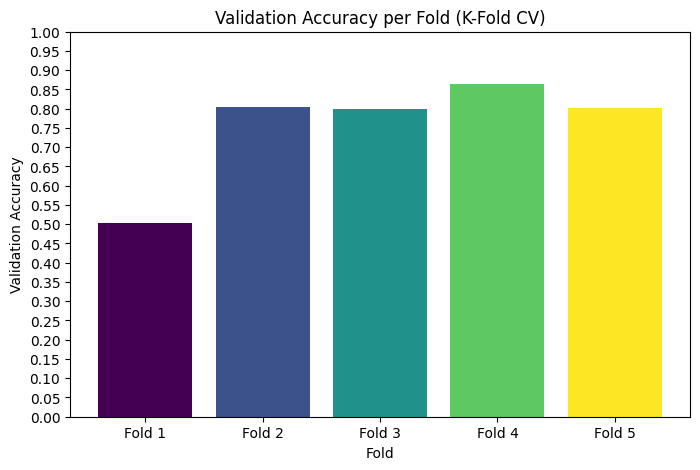

In [27]:

folds = range(1, len(val_accuracies) + 1)

plt.figure(figsize=(8, 5))
plt.bar(folds, val_accuracies, color=plt.cm.viridis(np.linspace(0, 1, len(val_accuracies))))
plt.xlabel('Fold')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy per Fold (K-Fold CV)')
plt.yticks(np.arange(0,1.1,0.05))
plt.ylim(0, 1)
plt.xticks(folds, [f'Fold {i}' for i in folds])
plt.show()

### 6.4 Neural Network Model Evaluation

Evaluate the trained neural network model on the test set and analyze performance metrics.

              precision    recall  f1-score   support

       happy       0.88      0.83      0.85      1079
         sad       0.83      0.88      0.85      1037

    accuracy                           0.85      2116
   macro avg       0.85      0.85      0.85      2116
weighted avg       0.86      0.85      0.85      2116



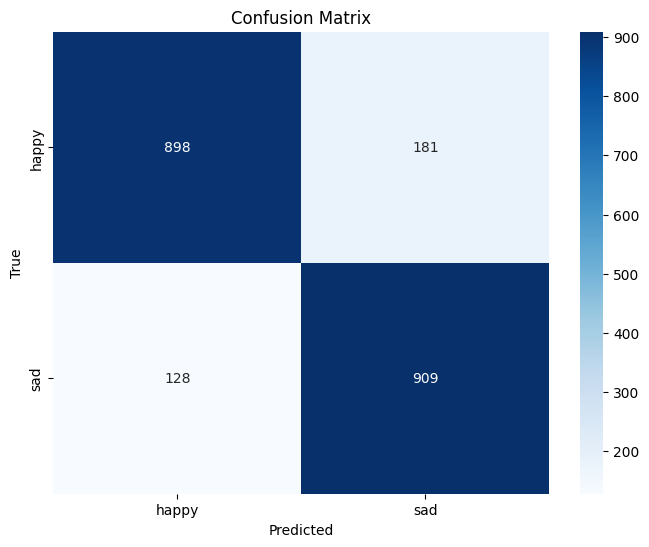

In [ ]:
y_pred = model.predict(np.array(x_test))
y_pred_classes = (y_pred > 0.5).astype(int).flatten()
print(classification_report(y_test, y_pred_classes, target_names=emotion_mapping.keys()))
conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_mapping.keys(), yticklabels=emotion_mapping.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

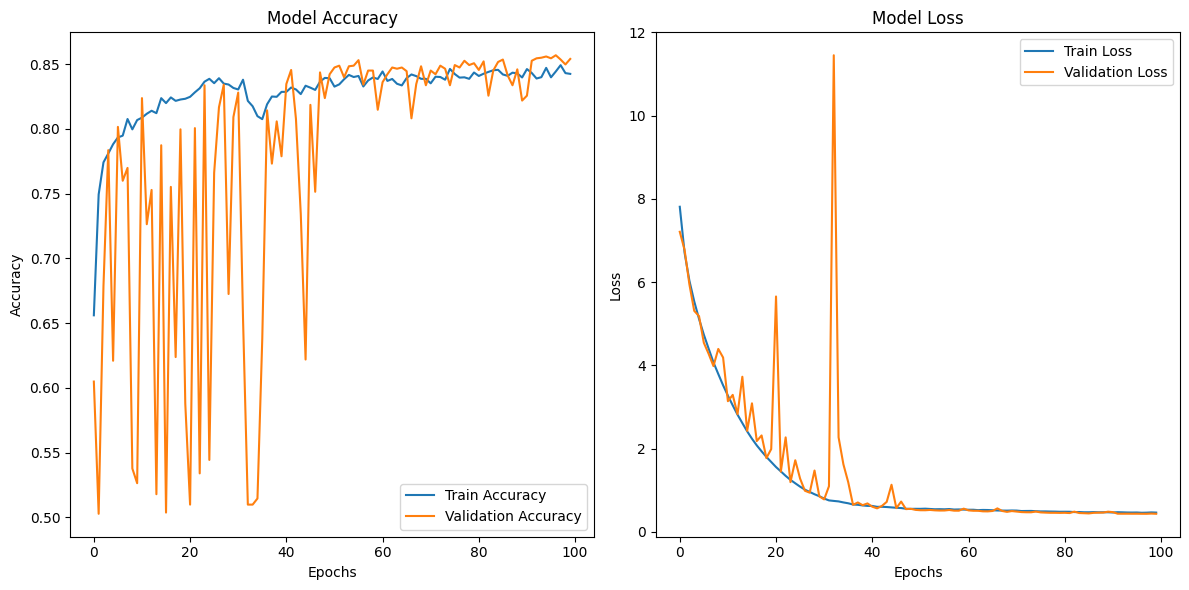

In [29]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

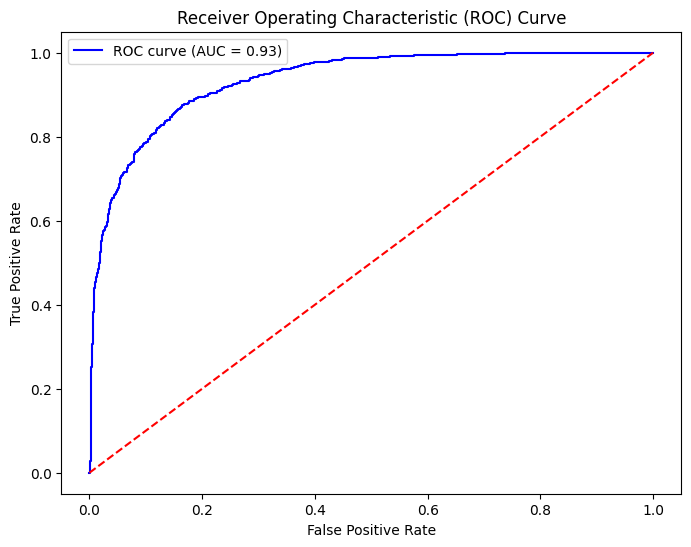

In [30]:


# Get predicted probabilities for the positive class
y_probs = model.predict(np.array(x_test)).flatten()  # shape: (n_samples,)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_probs, pos_label=1)
roc_auc = roc_auc_score(y_test, y_probs)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [31]:
#save the model
model.save('facial_model.keras')
